## Threshold moving
In this file we want to find optimal thresholds for each label.

We start from the network trained for 15 epochs with batch size 32, where only the final two extra layers were trainable.

Following the algorithm in the GHOST paper.

Good picture explaining the plots below: https://www.researchgate.net/figure/Example-distributions-of-outputs-of-a-classifier-algorithm-for-a-2-class-problem-The_fig1_344012378.

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import help_functions as hf

In [2]:
DATA_FOLDER = 'data/split_dataframes_heuristic_labels_20220914'
RESULTS_FOLDER = 'thesis_experiments/nr_train_layers_512bs_20epochs/6_339layers_algo_20classes_EfficientNetB2'
NR_LABELS = 20
BATCH_SIZE = 512
TARGET_SIZE = (64, 64)

# Y = 'thesis_experiments/imbalance_techniques_32bs_15epochs/0_algo_Falseaugment_20classes_Falseweights_EfficientNetB2/y_true_train.npy'
# P = 'thesis_experiments/imbalance_techniques_32bs_15epochs/0_algo_Falseaugment_20classes_Falseweights_EfficientNetB2/y_pred_train.npy'

In [3]:
model = hf.create_model(n_labels=NR_LABELS, image_dimension=TARGET_SIZE[0], model_name='EfficientNetB2', number_trainable_layers=339)
latest = tf.train.latest_checkpoint(RESULTS_FOLDER + '/checkpoints')
print(latest)
model.load_weights(latest)


Number of layers in basemodel: 339
Number of trainable layers: 339

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb2 (Functional)  (None, 2, 2, 1408)        7768569   
_________________________________________________________________
flatten (Flatten)            (None, 5632)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               721024    
_________________________________________________________________
dense_1 (Dense)              (None, 20)                2580      
Total params: 8,492,173
Trainable params: 8,424,598
Non-trainable params: 67,575
_________________________________________________________________
thesis_experiments/nr_train_layers_512bs_20epochs/6_339layers_algo_20classes_EfficientNetB2/checkpoints/cp-0004.ckpt


Extract the prediction probabilities for every instance in the training set

In [5]:
# Load training set dataframe and only keep the top 20 classes with regards to the number of attributed images
train_df = pd.read_json(DATA_FOLDER + '/train_df.json.bz2', compression='bz2')
top_classes = hf.get_top_classes(NR_LABELS, train_df)
print(f"Top {NR_LABELS} labels: {top_classes}")
# Only keep rows which have either of the top classes
ids_x_labels = train_df.labels.apply(lambda classes_list: any([True for a_class in top_classes if a_class in classes_list]))
training_set_x_labels = train_df[ids_x_labels]
training_set_x_labels['labels'] = train_df['labels'].apply(lambda labels_list: [label for label in labels_list if label in top_classes])
train_df = training_set_x_labels.copy()

datagen = ImageDataGenerator(validation_split=0.20)

train_generator = datagen.flow_from_dataframe(
        dataframe=train_df, 
        directory='/scratch/WIT_Dataset/images/', 
        seed=7,
        subset='training',
        color_mode='rgb',
        x_col='url', 
        y_col='labels', 
        class_mode='categorical', 
        batch_size=BATCH_SIZE,
        target_size=TARGET_SIZE)

validation_generator = datagen.flow_from_dataframe(
        dataframe=train_df, 
        directory='/scratch/WIT_Dataset/images/', 
        seed=7,
        subset='validation',
        color_mode='rgb',
        x_col='url', 
        y_col='labels', 
        class_mode='categorical', 
        batch_size=BATCH_SIZE,
        target_size=TARGET_SIZE)

class_labels = list(validation_generator.class_indices.keys())

probs_val = model.predict(validation_generator, verbose=1)
y_true_val = hf.get_y_true(shape=probs_val.shape, classes=validation_generator.classes)

# hf.plot_probs_and_best_threshold(y_true=y_true_val, probs=probs_val, labels=class_labels)

Found 760000 non-validated image filenames belonging to 42 classes.
Top 20 labels: ['Places' 'Society' 'Culture' 'People' 'Objects' 'History' 'Nature'
 'Events' 'Politics' 'Technology' 'Sports' 'Entertainment' 'Art'
 'Language' 'Architecture' 'Plants' 'Science' 'Music' 'Biology'
 'Landscapes']


<ipython-input-5-cecd4f836ba1>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_set_x_labels['labels'] = train_df['labels'].apply(lambda labels_list: [label for label in labels_list if label in top_classes])


Found 601978 validated image filenames belonging to 20 classes.
Found 150494 validated image filenames belonging to 20 classes.
294/294 [==============================] - 1948s 7s/step


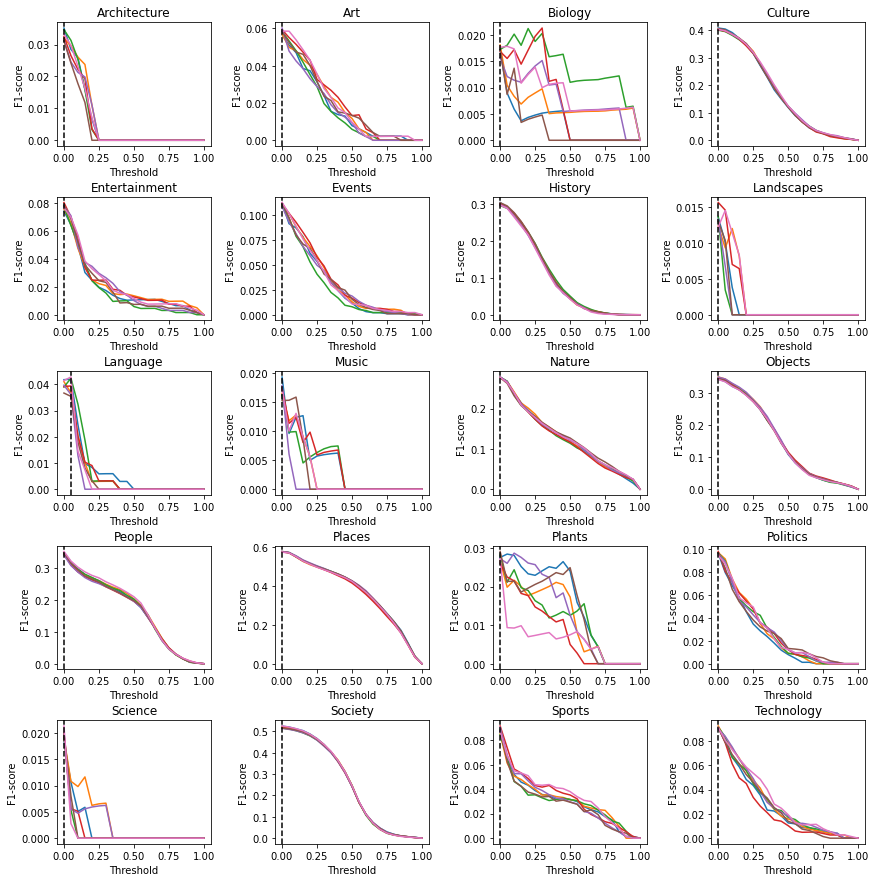

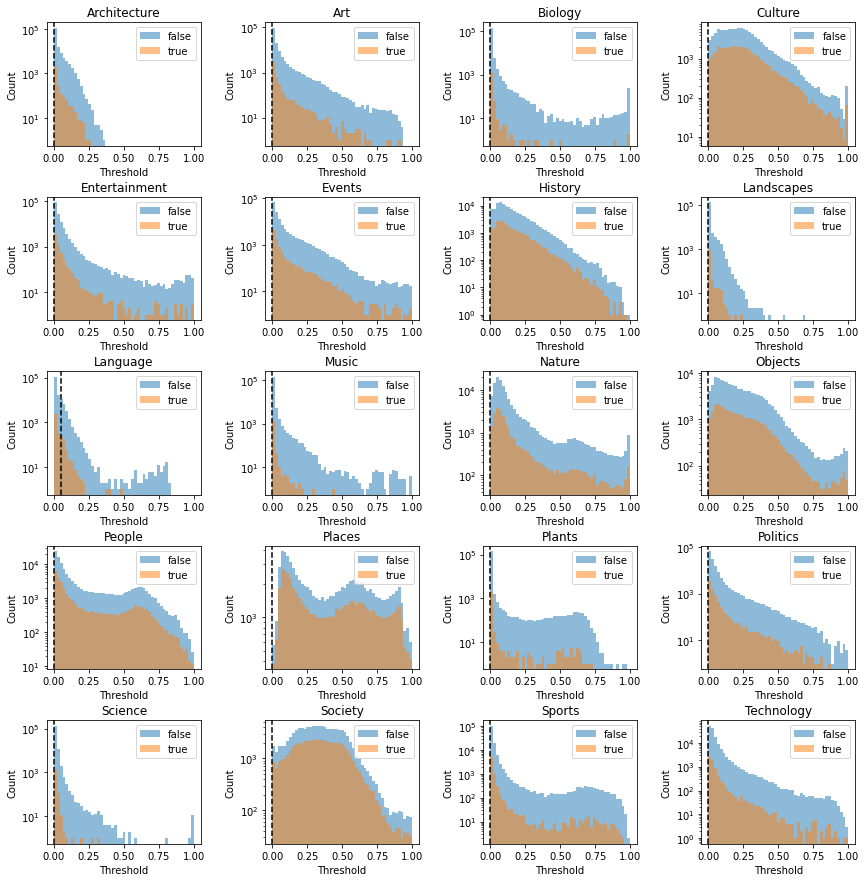

In [6]:
optim_thresholds = hf.get_optimal_threshold(y_true=y_true_val, probs=probs_val, thresholds=np.linspace(start=0, stop=1, num=21), labels=class_labels, N=7)

In [7]:
# Do this only to get the labels' names. There is certainly a better way to do this (e.g. pre-saving)
test_df = pd.read_json(DATA_FOLDER + '/test_df.json.bz2', compression='bz2')
top_classes = hf.get_top_classes(NR_LABELS, test_df) # OBS: are they always the same as top classes of train_df? In the 10-case yes.
# Only keep rows which have either of the top classes
ids_x_labels = test_df.labels.apply(lambda classes_list: any([True for a_class in top_classes if a_class in classes_list]))
test_set_x_labels = test_df[ids_x_labels]
test_set_x_labels['labels'] = test_df['labels'].apply(lambda labels_list: [label for label in labels_list if label in top_classes])
test_df = test_set_x_labels.copy()

datagen = ImageDataGenerator() 
test = datagen.flow_from_dataframe(
        dataframe=test_df, 
        directory='/scratch/WIT_Dataset/images',
        color_mode='rgb',
        x_col='url', 
        y_col='labels', 
        class_mode='categorical', 
        target_size=TARGET_SIZE,
        shuffle=False
        )
class_labels = list(test.class_indices.keys())

probs_test = model.predict(test, verbose=1)
y_true_test = hf.get_y_true(shape=probs_test.shape, classes=test.classes)

# hf.plot_probs_and_best_threshold(y_true=y_true_test, probs=probs_test, labels=class_labels)


Found 40000 non-validated image filenames belonging to 41 classes.


<ipython-input-7-7a251696074e>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set_x_labels['labels'] = test_df['labels'].apply(lambda labels_list: [label for label in labels_list if label in top_classes])


Found 39614 validated image filenames belonging to 20 classes.
1238/1238 [==============================] - 202s 163ms/step


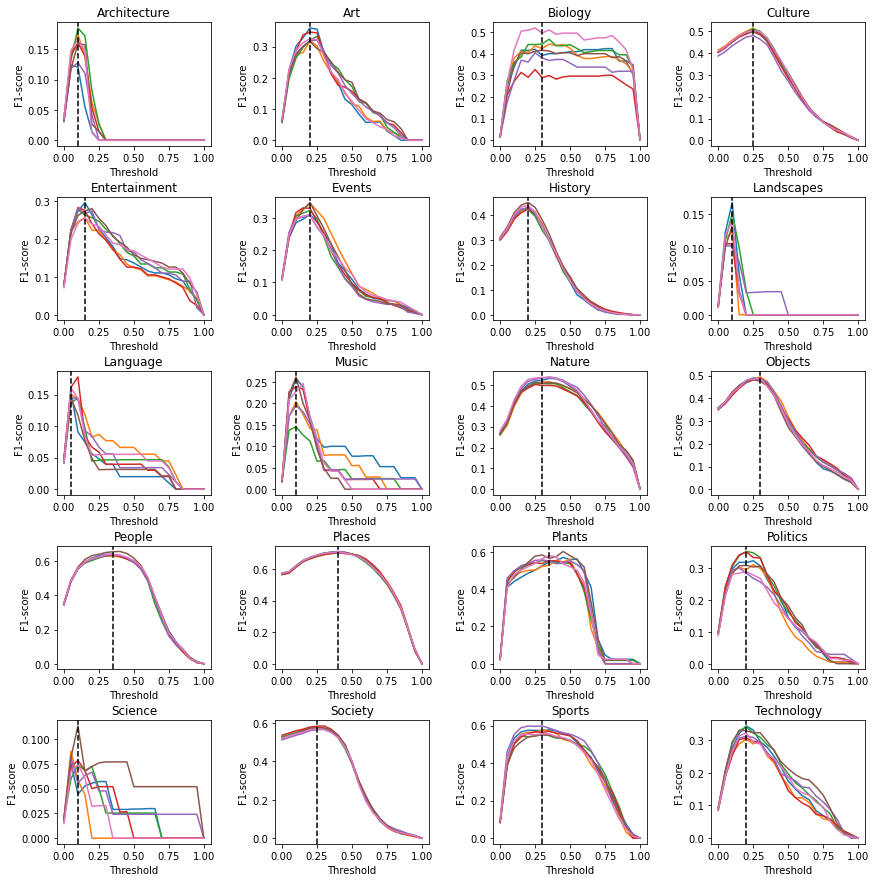

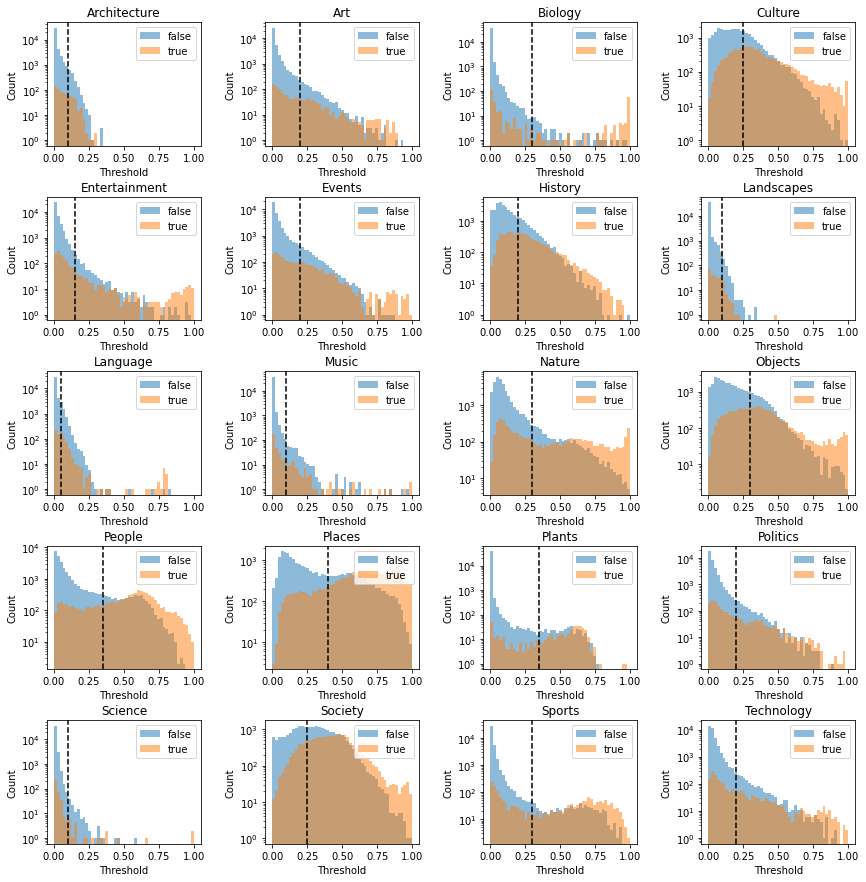

In [8]:
optim_thresholds = hf.get_optimal_threshold(y_true=y_true_test, probs=probs_test, thresholds=np.linspace(start=0, stop=1, num=21), labels=class_labels, N=7)

In [ ]:
y_true = np.load(file=Y)
probs = np.load(file=P)
best_thresholds = get_optimal_threshold(y_true=y_true, probs=probs, thresholds=np.linspace(start=0, stop=1, num=21), labels=class_labels)

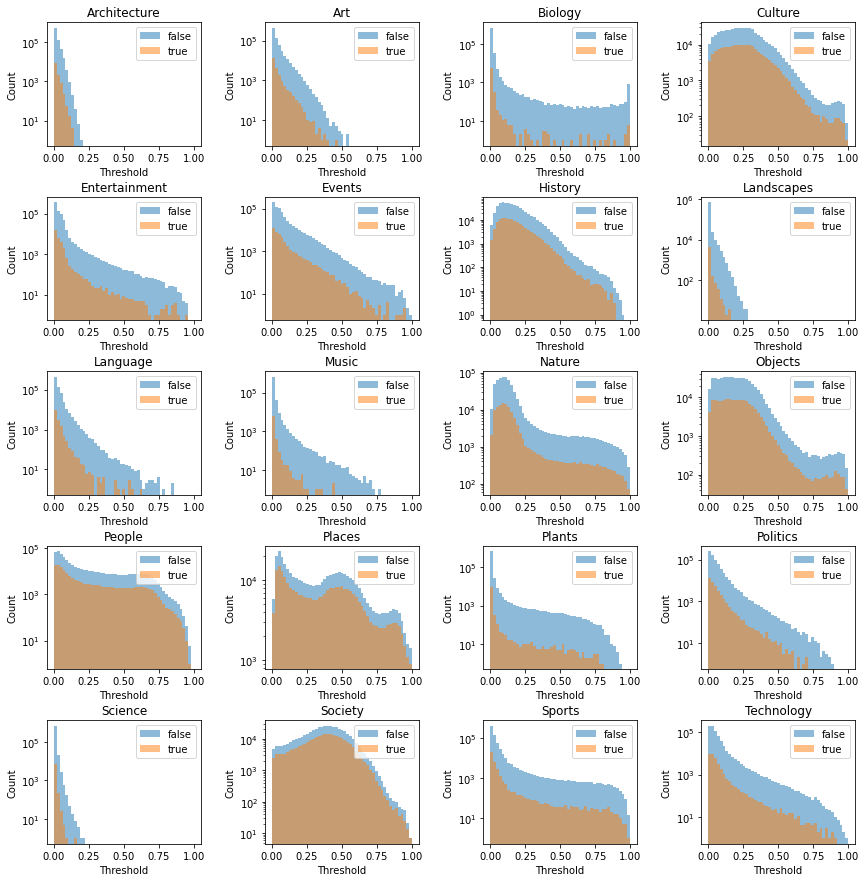

In [9]:
# Prediction probabilities for ground-truth TRUE and FALSE
fig, axs = plt.subplots(5, 4, figsize=(12, 12))
fig.tight_layout(h_pad=3.0, w_pad=3.0)
bins = np.linspace(0, 1, 50)
for label_idx, ax in zip(range(len(class_labels)), axs.flatten()):
    ax.hist(probs[y_true[:, label_idx] == 0][:, label_idx], bins, alpha=0.5, label='false', log=True)
    ax.hist(probs[y_true[:, label_idx] == 1][:, label_idx], bins, alpha=0.5, label='true', log=True)
    # ax.axvline(x=best_thresholds[label_idx], color='k', linestyle='--')
    ax.legend(loc='upper right')
    ax.set_title(class_labels[label_idx])
    ax.set_xlabel('Threshold')
    ax.set_ylabel('Count')